In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open('BankStatements.json', 'r') as file:
    bank_statements = json.load(file)

In [3]:
transactions = pd.DataFrame(bank_statements['Account']['Transactions']['Transaction'])

transactions['transactionTimestamp'] = pd.to_datetime(transactions['transactionTimestamp'])
transactions['valueDate'] = pd.to_datetime(transactions['valueDate'])

In [4]:
transactions['amount'] = pd.to_numeric(transactions['amount'], errors='coerce')

transactions = transactions.dropna(subset=['amount'])

# Transaction Analysis

In [5]:
total_transactions = transactions.shape[0]
print(f"Total number of transactions: {total_transactions}")

Total number of transactions: 985


## Small v/s Large Transactions

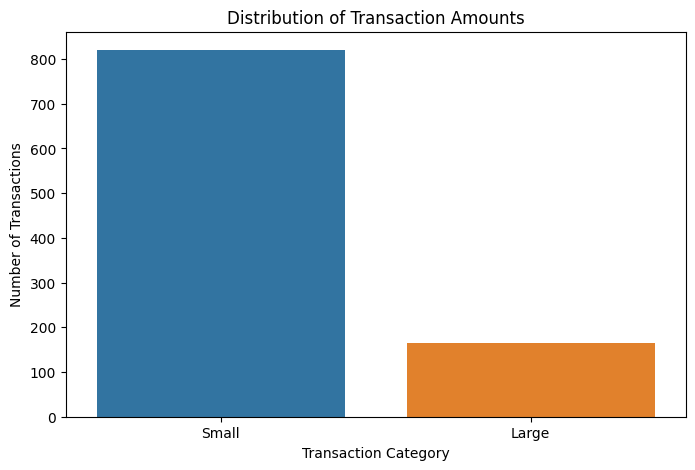

In [6]:
small_threshold = 1000
transactions['AmountCategory'] = transactions['amount'].apply(lambda x: 'Small' if x < small_threshold else 'Large')
transaction_distribution = transactions['AmountCategory'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=transaction_distribution.index, y=transaction_distribution.values)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Category')
plt.ylabel('Number of Transactions')
plt.show()

## Debit v/s Credit

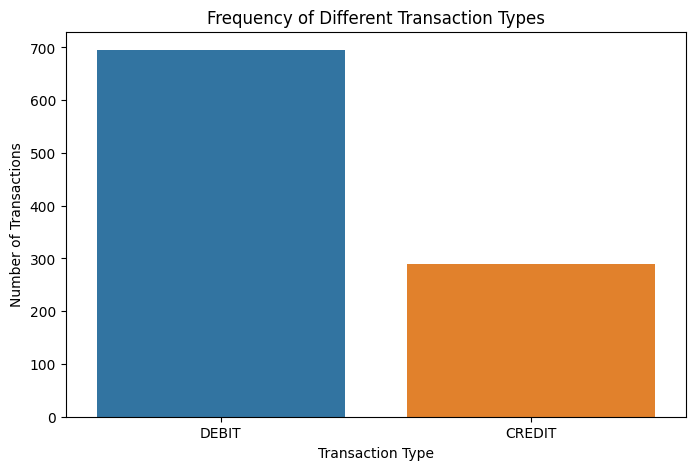

In [7]:
transaction_types = transactions['type'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=transaction_types.index, y=transaction_types.values)
plt.title('Frequency of Different Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.show()

In [9]:
small_large_counts = transactions['AmountCategory'].value_counts()

credit_debit_counts = transactions['type'].value_counts()

print("Frequency of Small and Large Transactions:")
print(small_large_counts)
print("\nFrequency of Credit and Debit Transactions:")
print(credit_debit_counts)

Frequency of Small and Large Transactions:
Small    820
Large    165
Name: AmountCategory, dtype: int64

Frequency of Credit and Debit Transactions:
DEBIT     695
CREDIT    290
Name: type, dtype: int64


# Balance Analysis

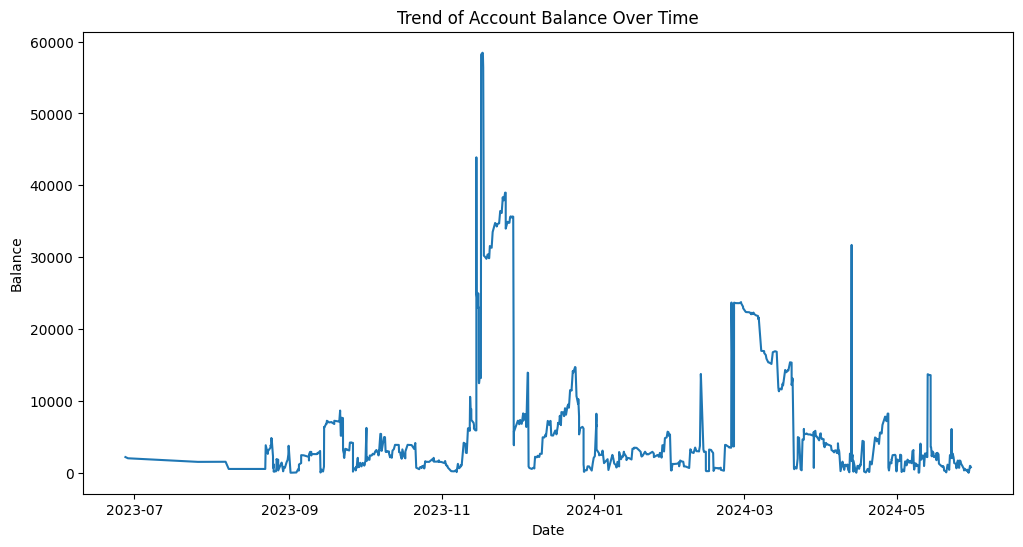

In [10]:
transactions['currentBalance'] = pd.to_numeric(transactions['currentBalance'], errors='coerce')
transactions = transactions.dropna(subset=['currentBalance'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='transactionTimestamp', y='currentBalance', data=transactions)
plt.title('Trend of Account Balance Over Time')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.show()

In [11]:
transactions['BalanceChange'] = transactions['currentBalance'].diff()
significant_changes = transactions[abs(transactions['BalanceChange']) > transactions['BalanceChange'].std()]
print("Periods with significant changes in the account balance:")
print(significant_changes[['transactionTimestamp', 'BalanceChange']])

Periods with significant changes in the account balance:
         transactionTimestamp  BalanceChange
51  2023-09-01 10:42:42+05:30        -3500.0
78  2023-09-14 21:14:51+05:30         5500.0
94  2023-09-21 13:05:06+05:30        -3500.0
136 2023-10-01 19:02:22+05:30         4550.0
138 2023-10-01 19:51:09+05:30        -4000.0
202 2023-10-21 16:17:48+05:30        -3300.0
259 2023-11-11 09:53:51+05:30         3440.0
265 2023-11-12 06:36:51+05:30         4730.0
275 2023-11-14 18:31:11+05:30        37999.0
277 2023-11-14 18:49:41+05:30       -16500.0
285 2023-11-15 17:48:21+05:30       -10000.0
291 2023-11-16 15:51:14+05:30        45000.0
295 2023-11-17 16:34:54+05:30       -21000.0
296 2023-11-17 18:32:29+05:30        -5200.0
322 2023-11-26 12:23:45+05:30        -5000.0
332 2023-11-29 16:15:33+05:30       -19000.0
333 2023-11-29 17:09:47+05:30       -12700.0
351 2023-12-05 07:08:30+05:30         7560.0
353 2023-12-05 15:50:06+05:30       -13000.0
419 2023-12-27 15:39:10+05:30        -5000.

# Spending Patterns

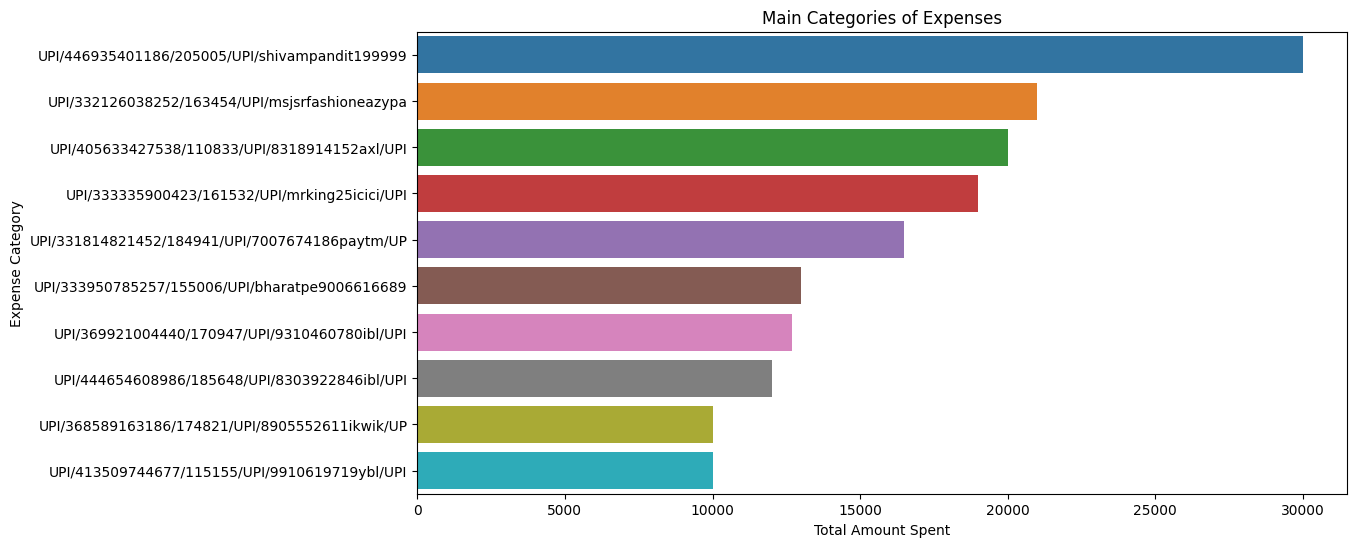

In [12]:
expense_categories = transactions[transactions['type'] == 'DEBIT'].groupby('narration')['amount'].sum().reset_index().sort_values(by='amount', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='amount', y='narration', data=expense_categories.head(10))
plt.title('Main Categories of Expenses')
plt.xlabel('Total Amount Spent')
plt.ylabel('Expense Category')
plt.show()

In [13]:
def categorize_transaction(narration):
    if 'FUEL' in narration.upper() or 'FILLING' in narration.upper():
        return 'Fuel'
    elif 'ECOMMERCE' in narration.upper() or 'AMAZON' in narration.upper() or 'FLIPKART' in narration.upper():
        return 'Ecommerce'
    elif 'FOOD' in narration.upper() or 'RESTAURANT' in narration.upper():
        return 'Food'
    elif 'SHOPPING' in narration.upper() or 'MALL' in narration.upper():
        return 'Shopping'
    elif 'ATM' in narration.upper() or 'CASH' in narration.upper():
        return 'ATM Withdrawals'
    elif 'UPI' in narration.upper() or 'PAY' in narration.upper():
        return 'UPI Transactions'
    else:
        return 'Others'

In [14]:
debit_transactions = transactions[transactions['type'] == 'DEBIT']

debit_transactions['category'] = debit_transactions['narration'].apply(categorize_transaction)

category_analysis = debit_transactions.groupby('category').agg(
    frequency=('amount', 'size'),
    total_amount=('amount', 'sum')
).reset_index()

category_analysis_sorted = category_analysis.sort_values(by='total_amount', ascending=False)

print(category_analysis_sorted)

           category  frequency  total_amount
2  UPI Transactions        688      407759.9
0   ATM Withdrawals          3       13500.0
1              Fuel          4         830.0


C:\Users\DELL\AppData\Local\Temp\ipykernel_54344\3041504016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debit_transactions['category'] = debit_transactions['narration'].apply(categorize_transaction)


# Income Analysis

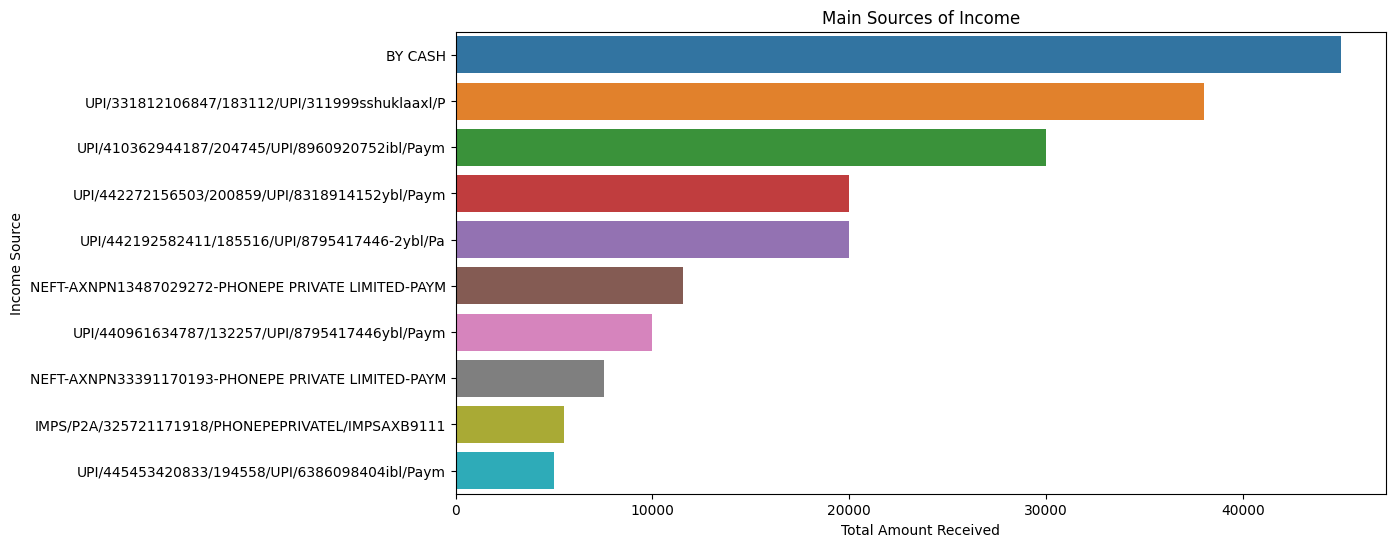

In [15]:
income_sources = transactions[transactions['type'] == 'CREDIT'].groupby('narration')['amount'].sum().reset_index().sort_values(by='amount', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='amount', y='narration', data=income_sources.head(10))
plt.title('Main Sources of Income')
plt.xlabel('Total Amount Received')
plt.ylabel('Income Source')
plt.show()

In [16]:
def categorize_income(narration):
    if 'SALARY' in narration.upper():
        return 'Salary'
    elif 'UPI' in narration.upper() or 'PAY' in narration.upper():
        return 'UPI Credits'
    elif 'INTEREST' in narration.upper():
        return 'Interest'
    elif 'REFUND' in narration.upper():
        return 'Refund'
    else:
        return 'Other Income'

In [17]:
credit_transactions = transactions[transactions['type'] == 'CREDIT']

credit_transactions['category'] = credit_transactions['narration'].apply(categorize_income)

income_analysis = credit_transactions.groupby('category').agg(
    frequency=('amount', 'size'),
    total_amount=('amount', 'sum')
).reset_index()

income_analysis_sorted = income_analysis.sort_values(by='total_amount', ascending=False)

print(income_analysis_sorted)

       category  frequency  total_amount
1   UPI Credits        259     351762.51
0  Other Income         31      68808.00


C:\Users\DELL\AppData\Local\Temp\ipykernel_54344\2689598118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_transactions['category'] = credit_transactions['narration'].apply(categorize_income)


C:\Users\DELL\AppData\Local\Temp\ipykernel_54344\2154095418.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  income_timing = transactions[transactions['type'] == 'CREDIT'].groupby(transactions['transactionTimestamp'].dt.to_period('M'))['amount'].sum().reset_index()


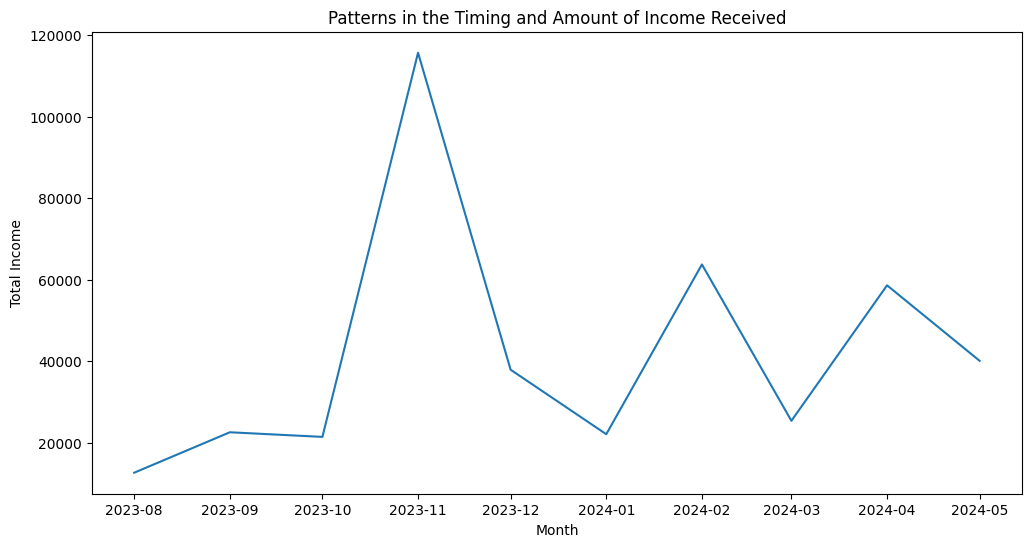

In [18]:
income_timing = transactions[transactions['type'] == 'CREDIT'].groupby(transactions['transactionTimestamp'].dt.to_period('M'))['amount'].sum().reset_index()
income_timing['transactionTimestamp'] = income_timing['transactionTimestamp'].dt.to_timestamp()
plt.figure(figsize=(12, 6))
sns.lineplot(x='transactionTimestamp', y='amount', data=income_timing)
plt.title('Patterns in the Timing and Amount of Income Received')
plt.xlabel('Month')
plt.ylabel('Total Income')
plt.show()

# Suspicious Transactions

In [19]:
suspicious_transactions = transactions[(transactions['amount'] > transactions['amount'].mean() + 3 * transactions['amount'].std()) | 
                                       (transactions['amount'] < transactions['amount'].mean() - 3 * transactions['amount'].std())]
print("Suspicious Transactions:")
print(suspicious_transactions)

Suspicious Transactions:
       type    mode   amount  currentBalance      transactionTimestamp  \
275  CREDIT     UPI  37999.0        43892.80 2023-11-14 18:31:11+05:30   
277   DEBIT     UPI  16500.0        27391.80 2023-11-14 18:49:41+05:30   
285   DEBIT     UPI  10000.0        12970.80 2023-11-15 17:48:21+05:30   
291  CREDIT    CASH  45000.0        58180.80 2023-11-16 15:51:14+05:30   
295   DEBIT     UPI  21000.0        35400.80 2023-11-17 16:34:54+05:30   
332   DEBIT     UPI  19000.0        16625.80 2023-11-29 16:15:33+05:30   
333   DEBIT     UPI  12700.0         3925.80 2023-11-29 17:09:47+05:30   
353   DEBIT     UPI  13000.0          865.80 2023-12-05 15:50:06+05:30   
535  CREDIT     UPI  10000.0        13744.81 2024-02-12 13:22:57+05:30   
537   DEBIT     ATM  10000.0         3244.81 2024-02-13 14:01:51+05:30   
570  CREDIT     UPI  20000.0        23483.91 2024-02-24 18:55:15+05:30   
572   DEBIT     UPI  20000.0         3683.91 2024-02-25 11:08:34+05:30   
576  CREDIT  

# Low Balance and High Expenditure Periods

In [20]:
low_balance_threshold = 5000
high_expenditure_threshold = transactions[transactions['type'] == 'DEBIT']['amount'].mean() + 2 * transactions[transactions['type'] == 'DEBIT']['amount'].std()  # Define a threshold for high expenditure

low_balance_periods = transactions[transactions['currentBalance'] < low_balance_threshold]
high_expenditure_periods = transactions[transactions['amount'] > high_expenditure_threshold]

print("Low Balance Periods:")
print(low_balance_periods[['transactionTimestamp', 'currentBalance']])

print("High Expenditure Periods:")
print(high_expenditure_periods[['transactionTimestamp', 'amount']])

Low Balance Periods:
         transactionTimestamp  currentBalance
0   2023-06-27 09:40:19+05:30         2180.80
1   2023-06-28 09:51:57+05:30         2010.80
2   2023-07-26 10:04:00+05:30         1510.80
3   2023-08-06 11:10:38+05:30         1525.80
4   2023-08-07 17:13:13+05:30          525.80
..                        ...             ...
980 2024-05-29 17:57:40+05:30           23.41
981 2024-05-30 05:07:05+05:30          961.41
982 2024-05-30 09:58:24+05:30          901.41
983 2024-05-30 13:30:30+05:30          771.41
984 2024-05-30 13:38:20+05:30          761.41

[694 rows x 2 columns]
High Expenditure Periods:
         transactionTimestamp   amount
78  2023-09-14 21:14:51+05:30   5500.0
275 2023-11-14 18:31:11+05:30  37999.0
277 2023-11-14 18:49:41+05:30  16500.0
285 2023-11-15 17:48:21+05:30  10000.0
291 2023-11-16 15:51:14+05:30  45000.0
295 2023-11-17 16:34:54+05:30  21000.0
296 2023-11-17 18:32:29+05:30   5200.0
332 2023-11-29 16:15:33+05:30  19000.0
333 2023-11-29 17:09:47+05